In [1]:
import pandas as pd
import numpy as np

In [2]:
readers = pd.read_csv("../data/readers.csv")
readers = readers.rename(columns={"id":"user_id", "art_id":"nzz_id"})
readers.head()

,user_id,nzz_id
0,1,ld.154103
1,1,ld.142559
2,1,1.18331199
3,1,ld.144819
4,1,ld.1293110


In [3]:
readers.shape

(27855, 2)

In [4]:
read_counts = readers["user_id"].value_counts(sort=True)
read_counts = read_counts.rename_axis("user_id").reset_index(name="read_count")

# Biorę pod uwagę tylko użytkowników, którzy przeczytali minimum 5 artykułów
min_read_count = 5
read_counts = read_counts[read_counts["read_count"] > min_read_count]

readers = readers[readers["user_id"].isin(read_counts["user_id"])]

In [5]:
# Train/Test split
from sklearn.model_selection import train_test_split

random_state = None
readers_train, readers_test = train_test_split(readers,
                                   stratify=readers["user_id"], 
                                   test_size=0.20,
                                   random_state=12)
                                   
print(f"Train set size {len(readers_train)}")
print(f"test set size {len(readers_test)}")
unique_train = readers_train["user_id"].unique()
unique_test = readers_test["user_id"].unique()
print(f"n art in test {len(unique_test)}")
print(f"n art in train {len(unique_train)}")


Train set size 22204
test set size 5551
n art in test 980
n art in train 980


In [6]:
def bootstrap_split(readers):
    all_samples = []
    for user in readers["user_id"].unique():
        all_samples.append(readers[readers["user_id"] == user].sample(3, replace=True))

    df_test = pd.concat(all_samples)
    df_train = pd.merge(readers, df_test, how='outer', indicator=True)
    df_train = df_train.loc[df_train["_merge"] == "left_only", ["user_id", "nzz_id"]]
    return df_train, df_test

In [7]:
all_samples = []
for user in readers["user_id"].unique():
    all_samples.append(readers[readers["user_id"] == user].sample(3, replace=True))
df_test = pd.concat(all_samples)
df_train = pd.merge(readers, df_test, how='outer', indicator=True)
df_train = df_train.loc[df_train["_merge"] == "left_only", ["user_id", "nzz_id"]]
return df_train, df_test

SyntaxError: 'return' outside function (<ipython-input-7-e9b4928289af>, line 7)

In [8]:
df_train.shape

(24954, 2)

In [9]:
df_test.shape

(2940, 2)

In [6]:
import sys
sys.path.append('../code')
from cf_model import CFModel
from model_evaluator import ModelEvaluator
from random_model import RandomModel
from implicit_model import ImplicitModel
from popularity_model import PopularityModel
model_evaluator = ModelEvaluator(k_list = [10])

In [9]:
#cf_recommender_model = CFModel(n_latent_factors=200)
cf_recommender_model = ImplicitModel(n_latent_factors=500, regularization=150, alpha=50, iterations=10)
cf_recommender_model.fit(readers_train)
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test, interactions=0)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

979 users processed

Global metrics:
{'modelName': 'implicit_model', 'recall@10': 0.4209191771946874, 'precision@10': 0.04209191771946874, 'f1_score@10': 0.07653075948994316, 'ndcg@10': 0.27505101752038413, 'personalization@10': 0.8392139000646224}


In [8]:
#cf_recommender_model = CFModel(n_latent_factors=200)
pop = PopularityModel()
pop.fit(readers_train)
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(pop, readers, readers_train, readers_test, interactions=0)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

979 users processed

Global metrics:
{'modelName': 'popularity_model', 'recall@10': 0.28014010366051184, 'precision@10': 0.028014010366051185, 'f1_score@10': 0.05093456430191124, 'ndcg@10': 0.16155640711378044, 'personalization@10': 1.1102230246251565e-16}


In [17]:
bootstrap_results = []
for i in range(10):
    train, test = bootstrap_split(readers)
    cf_recommender_model.fit(train)
    cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, train, test, interactions=0)
    bootstrap_results.append(cf_global_metrics)

In [16]:
print(bootstrap_results)

NameError: name 'bootstrap_results' is not defined

In [8]:
param_grid = {'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2],
              'alpha': [1, 10, 50, 100, 500, 1000]}

In [8]:
param_grid = {'num_factors': [100, 150, 200, 250, 300],
              'regularization': [100, 150, 200, 250, 300],
              'alpha': [50]}

In [16]:
#cf_recommender_model = CFModel(n_latent_factors=200)
cf_recommender_model = CFModel(n_latent_factors=200)
cf_recommender_model.fit(readers_train)
cf_global_metrics1, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

979 users processed

Global metrics:
{'modelName': 'implicit_model', 'recall@5': 0.3195703757693554, 'precision@5': 0.06391407515387107, 'f1_score@5': 0.10652345858978511, 'ndcg@5': 0.23286597852162383, 'recall@10': 0.40837180110139293, 'precision@10': 0.040837180110139294, 'f1_score@10': 0.07424941838207144, 'ndcg@10': 0.2601145417472888, 'recall@15': 0.4695286686103013, 'precision@15': 0.03130191124068675, 'f1_score@15': 0.05869108357628766, 'ndcg@15': 0.2787203405922709}


In [17]:
import altair as alt

In [19]:
global_m = [cf_global_metrics1, cf_global_metrics]
global_df = pd.DataFrame().from_dict(global_m)
global_df.head()

,modelName,recall@5,precision@5,f1_score@5,ndcg@5,recall@10,precision@10,f1_score@10,ndcg@10,recall@15,precision@15,f1_score@15,ndcg@15
0,CF_model,0.233746,0.046749,0.077915,0.168387,0.309816,0.030982,0.056330,0.190376,0.363676,0.024245,0.045459,0.205785
1,implicit_model,0.319570,0.063914,0.106523,0.232866,0.408372,0.040837,0.074249,0.260115,0.469529,0.031302,0.058691,0.278720


In [32]:

metrics_chart = alt.Chart(global_df, width=400).mark_bar(width=50).encode(
    x="modelName:O",
    y="recall@10:Q",
)
metrics_chart

alt.Chart(...)

In [9]:
grid_search_result = []
for n_latent_factors in param_grid["num_factors"]:
    for regularization in param_grid["regularization"]:
        for alpha in param_grid["alpha"]:
            cf_recommender_model = ImplicitModel(n_latent_factors=n_latent_factors, regularization=regularization, alpha=alpha, iterations=20)
            cf_recommender_model.fit(readers_train)
            cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
            grid_search_result.append({"parameters": {"num_factors": n_latent_factors, "regularization": regularization, "alpha": alpha}, "results": cf_global_metrics})


979 users processed
979 users processed
979 users processed
979 users processed
979 users processed


In [12]:
import json

with open('../output/grid_search_2d.json', 'w') as fp:
    json.dump(grid_search_result, fp)

In [22]:
cf_detailed_results_df

,hits@5_count,interacted_count,recall@5,precision@5,f1_score@5,ndcg@5,_person_id
406,5,10,0.5,0.10,0.166667,0.413093,197
520,4,10,0.4,0.08,0.133333,0.326186,804
100,2,10,0.2,0.04,0.066667,0.101778,397
276,2,10,0.2,0.04,0.066667,0.163093,353
35,2,10,0.2,0.04,0.066667,0.126186,859
...,...,...,...,...,...,...,...
877,0,1,0.0,0.00,0.000000,0.000000,240
730,0,1,0.0,0.00,0.000000,0.000000,293
335,1,1,1.0,0.20,0.333333,0.630930,477
698,0,1,0.0,0.00,0.000000,0.000000,18


In [11]:
cf_recommender_model = CFModel(n_latent_factors=80)
cf_recommender_model.fit(readers_train)
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

979 users processed

Global metrics:
{'modelName': 'CF_model', 'recall@10': 0.29857061872367996, 'precision@10': 0.029857061872367995, 'f1_score@10': 0.05428556704066908, 'ndcg@10': 0.17919520182667428}


In [ ]:
for metric, score in cf_global_metrics.items():
    if(metric == "modelName"):
        print(metric, score)
    else:
        print(metric, round(score, 2))

modelName CF_model
recall@1 0.1
precision@1 0.1
f1_score@1 0.1
ndcg@1 0.1
recall@2 0.14
precision@2 0.07
f1_score@2 0.09
ndcg@2 0.12
recall@3 0.18
precision@3 0.06
f1_score@3 0.09
ndcg@3 0.14
recall@4 0.21
precision@4 0.05
f1_score@4 0.08
ndcg@4 0.15
recall@5 0.23
precision@5 0.05
f1_score@5 0.08
ndcg@5 0.16
recall@6 0.25
precision@6 0.04
f1_score@6 0.07
ndcg@6 0.17
recall@7 0.26
precision@7 0.04
f1_score@7 0.07
ndcg@7 0.18
recall@8 0.28
precision@8 0.03
f1_score@8 0.06
ndcg@8 0.18
recall@9 0.29
precision@9 0.03
f1_score@9 0.06
ndcg@9 0.19
recall@10 0.31
precision@10 0.03
f1_score@10 0.06
ndcg@10 0.19
recall@11 0.32
precision@11 0.03
f1_score@11 0.05
ndcg@11 0.19
recall@12 0.33
precision@12 0.03
f1_score@12 0.05
ndcg@12 0.2
recall@13 0.34
precision@13 0.03
f1_score@13 0.05
ndcg@13 0.2
recall@14 0.35
precision@14 0.02
f1_score@14 0.05
ndcg@14 0.2
recall@15 0.36
precision@15 0.02
f1_score@15 0.05
ndcg@15 0.2
recall@16 0.37
precision@16 0.02
f1_score@16 0.04
ndcg@16 0.21
recall@17 0.37
pr

In [ ]:
global_df = pd.DataFrame().from_dict(cf_global_metrics.items())[1:].rename({0: "metric", 1: "score"}, axis =1)
splitted = global_df["metric"].str.split("@", expand=True)
global_df["metric"] = splitted[0]
global_df["k"] = splitted[1]

global_df["score"] = global_df["score"].astype("float64")
global_df["k"] = global_df["k"].astype("int64")

In [ ]:
import altair as alt

metrics_chart = alt.Chart(global_df).mark_line().encode(
    x="k:Q",
    y="score:Q",
    color="metric:N"
)
metrics_chart.save("../output/metrics_chart.html")

In [ ]:
pivoted = global_df.pivot(index="k", columns="metric", values="score").reset_index()

precision_recall_curve = alt.Chart(pivoted).mark_line().encode(
    x="recall:Q",
    y="precision:Q"
)
precision_recall_curve.save("../output/precision_recall_curve.html")

In [ ]:
print(pivoted["precision"].mean())
print(pivoted["recall"].mean())
print(pivoted["ndcg"].mean())
print(pivoted["f1_score"].mean())

0.03684176001138091
0.2918602405247813
0.1806010562490465
0.05968966771760357


In [ ]:
cf_recommender_model.recommend(1)

,nzz_id,recommendation_strength
0,ld.150557,0.978685
1,ld.141732,0.978677
2,ld.147794,0.977957
3,ld.152926,0.975086
4,ld.1293241,0.958722
5,ld.142670,0.951331
6,1.18179552,0.951331
7,ld.821045,0.946769
8,ld.153885,0.942052
9,ld.1085571,0.941433


In [ ]:
cf_recommender_model = CFModel(n_latent_factors=200)
bootstrap_results = []
for i in range(0, 500):
    readers_train, readers_test = train_test_split(
        readers, stratify=readers["user_id"], test_size=0.20
    )

    cf_recommender_model.fit(readers_train)

    cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
    bootstrap_results.append(cf_global_metrics)
    print('\nGlobal metrics:\n%s' % cf_global_metrics)
    print(f"{i} Iteration", end="\r", flush=True)

KeyboardInterrupt: 

In [6]:
cf_recommender_model = CFModel(n_latent_factors=200)

cf_recommender_model.fit(readers_train)

cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

999 users processed

Global metrics:
{'modelName': 'CF_model', 'recall@5': 0.23083826961048287, 'recall@10': 0.30820319511757316, 'coverage@5': 16.75, 'coverage@10': 24.86, 'personalization@5': 0.9953633633633634, 'personalization@10': 0.9925331331331332}


In [13]:
bootstrap_results_df = pd.DataFrame(bootstrap_results)
bootstrap_results_df.head()
bootstrap_results_df.to_csv("../data/bootstra_results.csv", encoding="utf-8", index=False)

In [12]:
unpivot_results = bootstrap_results_df.melt(id_vars=["modelName"], var_name="k", value_name="recall@k")
unpivot_results["k"] = unpivot_results["k"].str.replace("recall@", "")
unpivot_results.head()

,modelName,k,recall@k
0,CF_model,5,0.215940
1,CF_model,5,0.221325
2,CF_model,5,0.226530
3,CF_model,5,0.214324
4,CF_model,5,0.226351


recall@5| mean: 0.22 stdev: 0.0048
recall@10| mean: 0.31 stdev: 0.0053


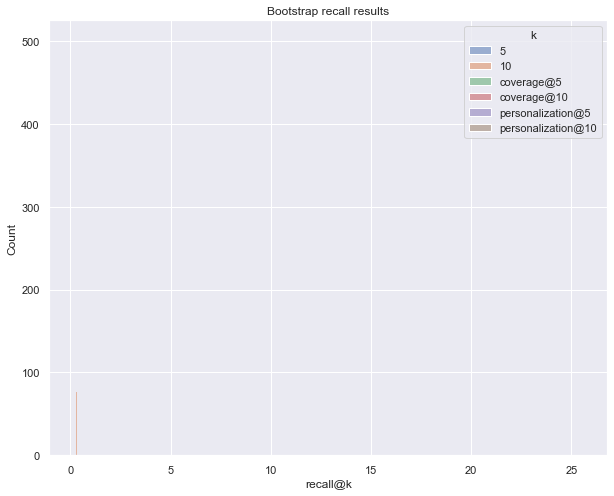

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

plt.figure(figsize=(10, 8))
ax = plt.axes()

sns.histplot(unpivot_results, x="recall@k", hue="k", binwidth=0.002, ax=ax)
ax.set_title("Bootstrap recall results")

mean_recall_at_5 = unpivot_results[unpivot_results["k"] == "5"]["recall@k"].mean()
mean_recall_at_10 = unpivot_results[unpivot_results["k"] == "10"]["recall@k"].mean()

stdev_recall_at_5 = unpivot_results[unpivot_results["k"] == "5"]["recall@k"].std()
stdev_recall_at_10 = unpivot_results[unpivot_results["k"] == "10"]["recall@k"].std()

print(f"recall@5| mean: {mean_recall_at_5:.2f} stdev: {stdev_recall_at_5:.4f}")
print(f"recall@10| mean: {mean_recall_at_10:.2f} stdev: {stdev_recall_at_10:.4f}")

In [ ]:

cf_recommender_model = CFModel(n_latent_factors=200)
cf_recommender_model.fit(readers_train)

print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')

cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model, readers, readers_train, readers_test)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
#cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
999 users processed

Global metrics:
{'modelName': 'CF_model', 'recall@5': 0.22724824986537426, 'recall@10': 0.3132292227607252}


In [7]:
articles = pd.read_csv("../data/articles_cleaned.csv")
random_model = RandomModel()
random_model.fit(articles)

print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(random_model, readers, readers_train, readers_test)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
#cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
999 users processed

Global metrics:
{'modelName': 'random_model', 'recall@5': 0.04900376952073236, 'recall@10': 0.09746903607969844, 'coverage@5': 44.58, 'coverage@10': 79.93, 'personalization@5': 0.9997721721721722, 'personalization@10': 0.9995373373373373}


In [ ]:
cf_recommender_model.recommend(221, topn=5).sort_values(by=["recommendation_strength"], ascending=False)

,nzz_id,recommendation_strength
0,ld.138721,0.476928
1,ld.154622,0.269609
2,1.18219961,0.221701
3,ld.142462,0.215890
4,ld.151075,0.211742


In [ ]:
cf_detailed_results_df.sort_values(by=["recall@5"], ascending=False).head(20)

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
958,1,1,1,1.000000,1.0,896
951,1,1,1,1.000000,1.0,685
919,1,1,1,1.000000,1.0,167
902,2,3,3,0.666667,1.0,720
390,1,1,2,0.500000,0.5,528
385,1,1,2,0.500000,0.5,687
886,1,2,2,0.500000,1.0,321
967,1,1,2,0.500000,0.5,277
932,1,1,2,0.500000,0.5,229
981,1,2,2,0.500000,1.0,237


In [ ]:
recommended_items = cf_recommender_model.recommend(17)

recommended_items.head(3)

,nzz_id,recommendation_strength
0,1.18108994,0.749262
1,ld.137200,0.504214
2,1.18097718,0.224044


In [ ]:
articles = pd.read_csv("../data/articles_cleaned.csv")
articles = articles[articles["nzz_id"].isin(recommended_items["nzz_id"])]
articles

,nzz_id,author,catchline,department,lead_text,pub_date,title,paragraph
1232,1.17334814,Unknown,100 Jahre Jungfraubahn,Mobilität,Am 1. August 1912 wurde die Jungfraubahn in Be...,2017-04-11 13:57:27.958,100 Jahre Jungfraubahn,NaN
2098,ld.150839,Franziska Engelhardt,Was heute wichtig ist,Briefing,Türkei kritisiert den «Blick» / Einigungskonfe...,2017-03-13 19:15:00.0,Was heute wichtig ist,Türkei kritisiert den «Blick» / Einigungskonfe...
2820,1.18097718,Unknown,«Overdrive: L. A. Constructs the Future»,Feuilleton,Los Angeles ist ein gerne zitiertes Beispiel i...,2017-04-11 13:59:41.131,«Overdrive: L. A. Constructs the Future»,NaN
3047,ld.143506,"Valerie Zaslawski, Bern",Tages-Massentourismus,Schweiz,Nicht alle haben ihre Freude an den flüchtigen...,2017-02-08 09:00:00.0,"Er kam, sah –xa0und verschwand",Nicht alle haben ihre Freude an den flüchtigen...
4129,ld.150490,Unknown,Ölpreis erholt sich,Finanzen,Der Ölpreis zeigt sich derzeit sehr volatil un...,2017-05-15 06:50:00.0,Saudiarabien und Russland kämpfen gemeinsam ge...,cts./tsf. (dpa/Reuters) · Der Erdölmarkt sche...
5249,ld.150923,Peter Keller,Die Frage der Woche,Gesellschaft,T. Z. aus R. hat kürzlich zwei Weine aus dem A...,2017-03-14 04:30:00.0,Werden die Weine aus der Region St. Gallen unt...,T. Z. aus R. hat kürzlich zwei Weine aus dem A...
7440,1.18108994,Unknown,Impressionen aus Tessin und Graubünden,Tessin,Die Kantone Graubünden und Tessin (Gastkanton ...,2017-04-11 13:59:48.182,Impressionen aus Tessin und Graubünden,NaN
9719,ld.147305,Unknown,Arbeitspendler,Schweiz,Die Schweiz bleibt ein Magnet für Arbeitspendl...,2017-02-23 10:29:45.0,Fast 320'000 Grenzgänger arbeiten in der Schweiz,Die Schweiz bleibt ein Magnet für Arbeitspendl...
15027,ld.138132,Nina Fargahi,Was heute wichtig ist,Briefing,Tote nach Explosion in Izmir / Serbien will Ha...,2017-01-05 05:01:52.0,Was heute wichtig ist,Tote nach Explosion in Izmir / Serbien will Ha...
18907,ld.137200,Unknown,Ein letzter Blick zurück,Jahresrückblick 2016,"Die grossen Themen in der Bilanz, die besten G...",2017-01-02 04:30:00.0,Der grosse NZZ-Jahresrückblick,NaN


## Parameter tuning

In [ ]:
#n_latent_factors_list = range(5, 100, 5)
#metrics = []
#
#for n_latent_factors in n_latent_factors_list:
#    recommender = CFModel(n_latent_factors=n_latent_factors)
#    recommender.fit(readers_train)
#    cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(recommender)
#    metrics.append({"n_latent_factors": n_latent_factors, "metrics": cf_global_metrics})

In [ ]:
#for metric in metrics:
#    print(metric["n_latent_factors"], metric["metrics"])

In [ ]:
def get_coverage(predicted, catalog):
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

In [ ]:
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
def personalization(predicted):
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted):
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

In [ ]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]["nzz_id"]
    return set(
        interacted_items
        if type(interacted_items) == pd.Series
        else [interacted_items]
    )

In [ ]:
interactions_full_indexed_df = readers.set_index("user_id")
interactions_train_indexed_df = readers_train.set_index("user_id")
interactions_test_indexed_df = readers_test.set_index("user_id")

In [ ]:

# Coverage evaluation
#TODO: Przenieść coverage i personalization do model evaluator
def evaluate_coverage_personalization(model, topn=5):
    all_recs = []
    for idx, person_id in enumerate(list(readers_train["user_id"].unique().tolist())):
            person_recs_df = model.recommend(person_id, articles_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), topn=topn)
            all_recs.append(person_recs_df["nzz_id"].values)

    coverage_result = get_coverage(all_recs, interactions_train_indexed_df["nzz_id"].unique())
    personalization_result = personalization(all_recs)
    
    

    return coverage_result, personalization_result



In [ ]:
evaluate_coverage(cf_recommender_model, topn=5)


Model: CF_model pokrywa: 16.58% artykułów
Model: CF_model personalizacja: 0.995352952952953
